## Thermal Conductivity Fit Analysis
Developed by Henry Nachman

Last Edited: 22 February 2024

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# note : most functions needed for running this notebook can be found in tc_utils.
from tc_utils import *

First, we need to find where all our RAW data is

In [2]:
path_to_lib = f"{os.getcwd()}\\lib"
mat_directories = [folder for folder in os.listdir(path_to_lib) if not folder.endswith(".md")]

path_to_RAW = dict()
for mat in mat_directories:
    raw_str = f"{path_to_lib}\\{mat}\\RAW"
    path_to_RAW[mat] = raw_str


print(path_to_RAW)

{'Clearwater': 'c:\\Users\\henac\\OneDrive - The University of Texas at Austin\\01_RESEARCH\\05_CMBS4\\Cryogenic_Material_Properties\\thermal_conductivity\\lib\\Clearwater\\RAW', 'DPP': 'c:\\Users\\henac\\OneDrive - The University of Texas at Austin\\01_RESEARCH\\05_CMBS4\\Cryogenic_Material_Properties\\thermal_conductivity\\lib\\DPP\\RAW', 'Graphlite': 'c:\\Users\\henac\\OneDrive - The University of Texas at Austin\\01_RESEARCH\\05_CMBS4\\Cryogenic_Material_Properties\\thermal_conductivity\\lib\\Graphlite\\RAW', 'SS304': 'c:\\Users\\henac\\OneDrive - The University of Texas at Austin\\01_RESEARCH\\05_CMBS4\\Cryogenic_Material_Properties\\thermal_conductivity\\lib\\SS304\\RAW'}


This function will fit the data to polynomials. The fit is done in two stages, a low end fit and a high end fit. The two fits are then connected using an Error Function centered at the discontinuity.

In [3]:
def dual_tc_fit(big_data, save_path, erf_loc = 20, fit_orders = (3,3), fit_types=("k/T", "loglog"), plots=False):
    """
    Arguments :
    - big_data   - Array of measurement data concatenated (should be of shape: [N, 3])
    - save_path  - File path to publish output files and plots.
    - erf_loc     - default=20    - Temperature at which to split the data for fitting (and to place the error function).
    - fit_orders - default=(3,3) - Polynomial fit order (low, high).
    - fit_types  - default=("k/T", "loglog") - defines the type of fit for each regime (low, high).
    - plots      - default=False - Boolean argument, if true, plots are made and saved to save_path.

    Returns :
    - arg_dict - Dictionary of fit arguments - includes low fit, high fit, and combined fit arguments.
    """
    
    dsplit = split_data(big_data, erf_loc)
    lowT, lowT_k, lowT_koT, low_ws, hiT, hiT_k, hiT_koT, hi_ws = dsplit

    # Take a log10 of the high range
    log_hi_T = np.log10(hiT)
    log_hi_k = np.log10(hiT_k)
    # Fit the low data
    try:
        if (fit_types[0] == "k/T") and (len(lowT)!=0):
            low_fit_xs, low_fit = koT_function(lowT, lowT_koT, fit_orders[0], low_ws)
        elif (len(lowT)==0):
            low_fit = [0]
            print(f"Only using high fit {min(T)} > 20")

        # Fit the high data
        
        if fit_types[1] == "loglog" and (len(hiT)!=0):
            hi_fit_xs, hi_fit = logk_function(log_hi_T, log_hi_k, fit_orders[1], hi_ws)
        elif (len(hiT)==0):
            hi_fit = [0]
            print(f"Only using low fit {max(T)} < 20")

    except np.linalg.LinAlgError:
        print("LinAlgError - likely not enough points after weight to fit the data.")
        raise np.linalg.LinAlgError()
        
    # # Combine the fits
    # xrange_total = np.linspace(min(lowT), max(hiT), 100)
    # logk = loglog(xrange_total, low_poly1d, hi_poly1d, erf_place)
    # #

    if plots:
        fig, axs = plt.subplots(2, figsize=(8, 6))
        axs[0].plot(lowT, lowT_koT,'.')
        axs[0].plot(low_fit_xs, np.polyval(low_fit, low_fit_xs))
        axs[0].set_xlabel("T")
        axs[0].set_ylabel("k/T")
        axs[0].title.set_text("Low Temperature Fit")
        axs[1].loglog(10**hi_fit_xs, 10**np.polyval(hi_fit, hi_fit_xs))
        axs[1].loglog(hiT, hiT_k, '.')
        axs[1].grid(True, which="both", ls="-", color='0.65')
        axs[1].set_ylabel("k")
        axs[1].set_xlabel("T")
        axs[1].title.set_text("High Temperature Fit")
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        plt.savefig(f"{save_path}\\fits_subplots.pdf", dpi = 300, format="pdf")
        plt.show()
        plt.clf()


    arg_dict = make_arg_dict(low_fit, low_fit_xs, hi_fit, hi_fit_xs, fit_orders, fit_types, erf_loc)
    return arg_dict

def koT_function(T, koT, orders, weights):
    low_fit_xs = np.linspace(np.min(T), np.max(T), 100)
    lofit_full = np.polyfit(T, koT, orders, full=True, w=weights)
    low_fit, residuals_lo, rank_lo, sing_vals_lo, rcond_lo = lofit_full
    low_poly1d = np.poly1d(low_fit)
    return low_fit_xs, low_fit

def logk_function(logT, logk, orders, weights):
    fit_T = np.linspace(np.min(logT), np.max(logT), 100)
    fit_full = np.polyfit(logT, logk, orders, full=True, w=weights)
    fit, residuals_hi, rank_hi, sing_vals_hi, rcond_hi =  fit_full
    # hi_poly1d = np.poly1d(fit)
    return fit_T, fit

def make_arg_dict(low_fit, low_fit_xs, hi_fit, hi_fit_xs, fit_orders, fit_types, erf_loc):
    low_func = f"{fit_orders[0]} order {fit_types[0]}"
    hi_func = f"{fit_orders[1]} order {fit_types[1]}"
    
    low_param = np.array(low_fit)
    hi_param = np.array(hi_fit)
    
    all_params = np.append(np.append(low_param, hi_param), erf_loc)

    arg_dict = {"low_function_type"  : low_func,
                "low_fit_param"      : low_param.tolist(),
                "low_fit_range"      : np.array([min(low_fit_xs), max(low_fit_xs)]).tolist(),
                "hi_function_type"   : hi_func,
                "hi_fit_param"       : hi_param.tolist(),
                "hi_fit_range"       : np.array([10**min(hi_fit_xs), 10**max(hi_fit_xs)]).tolist(),
                "combined_function_type" : "loglog",
                "combined_fit_param" : all_params.tolist(),
                "combined_fit_range" : np.array([min(low_fit_xs), max(hi_fit_xs)]).tolist()}
    return arg_dict

def split_data(big_data, erf_loc):
    # divide the data array into three columns
    T, k, koT, weights = [big_data[:,0], big_data[:,1], big_data[:,2], big_data[:,3]]

    

    # Find the low range
    # lowT, hiT = [T[T<erf_loc], T[T>erf_loc]]
    
    # if (len(lowT) == 0) or (len(hiT) ==0):
    #     print("ERROR  - data split results in 0-length array, please adjust split location")
    #     print(f"NOTE   - min(T) = {min(T)}, max(T) = {max(T)} ")
    #     print(f"{(len(lowT))} {(len(hiT))}")

    #     erf_loc = np.mean(T)

    low_ws, hi_ws = [weights[T<erf_loc], weights[T>erf_loc]]

    # Find the low range
    lowT, lowT_k, lowT_koT = [T[T<erf_loc], k[T<erf_loc], koT[T<erf_loc]]
    
    # Find the high range
    hiT, hiT_k, hiT_koT = [T[T>erf_loc], k[T>erf_loc], koT[T>erf_loc]]

    return [lowT, lowT_k, lowT_koT, low_ws, hiT, hiT_k, hiT_koT, hi_ws]


Log10 k = Log10 [aT+bT^2+cT^3+3E-9T^5]*0.5*[1-ERF(15(Log10T-1.48)]+[d+eLog10T+f(Log10T)^2+g(log10T)^3+hEXP^(Log10T)]*0.5*[1+ERF(15(Log10T-1.48)]

Let's run our fitting code for every material found in the library.

4.842 0.1335
Using a low fit.


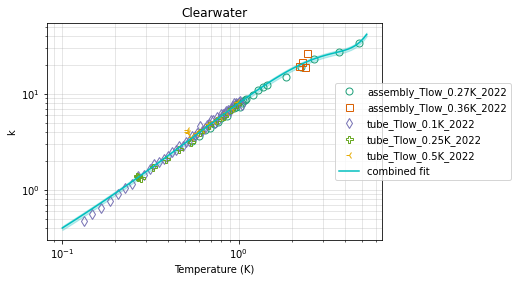

<Figure size 432x288 with 0 Axes>

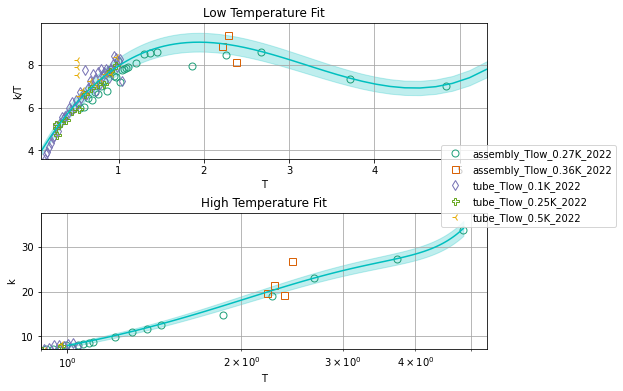

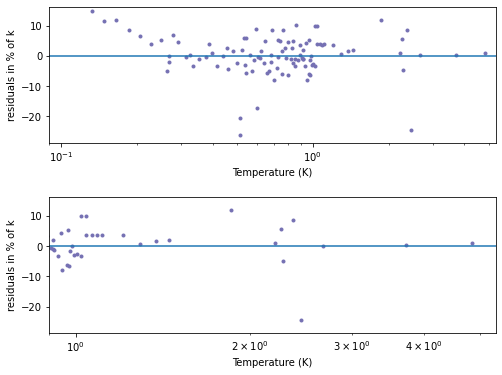

4.02 0.6975
Using a low fit.


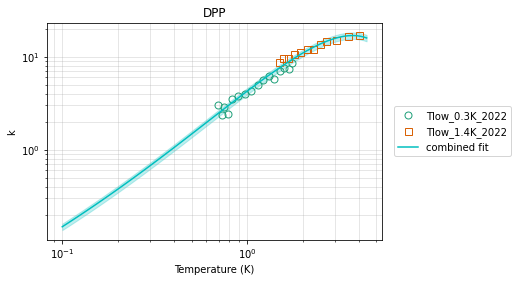

<Figure size 432x288 with 0 Axes>

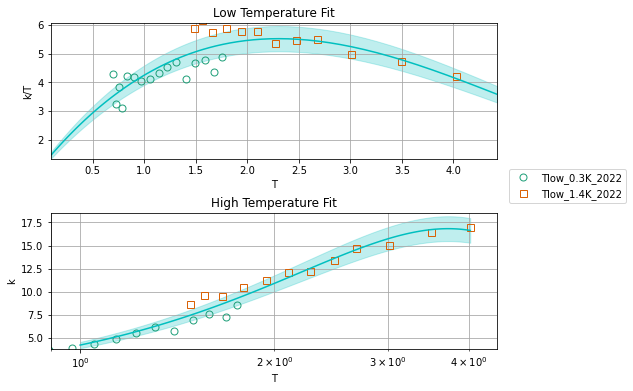

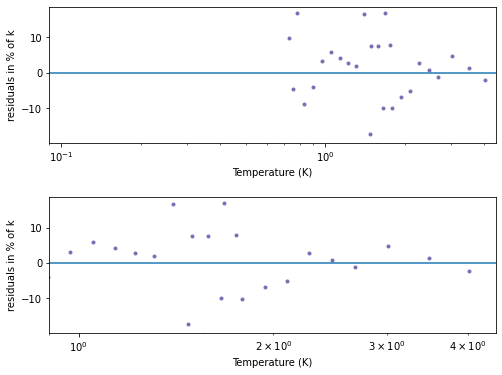

4.015 1.4875
Using a low fit.


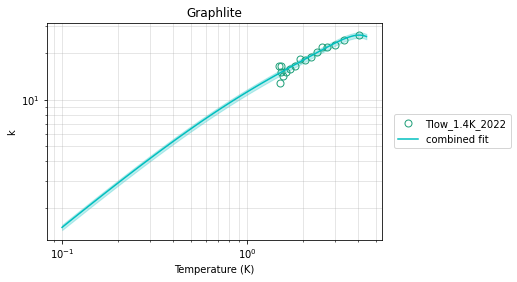

<Figure size 432x288 with 0 Axes>

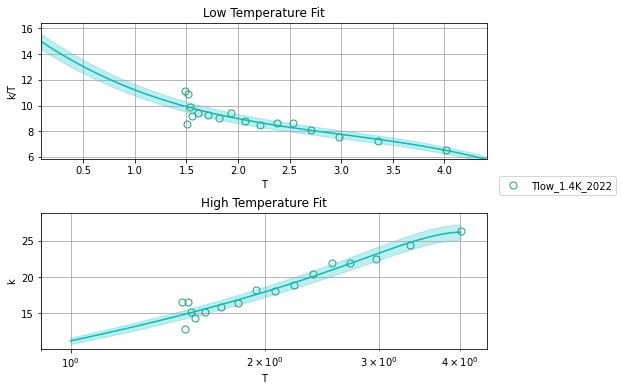

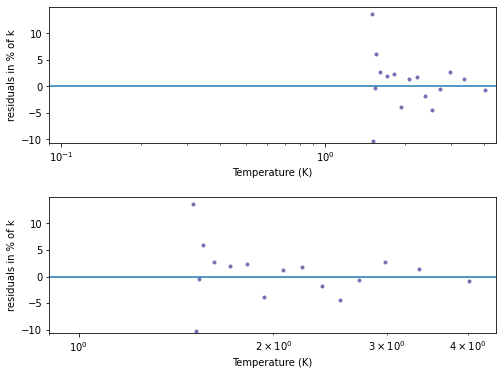

1672.0 0.3846
Using a combined fit.
[3.8460000e-01 1.1978570e+02 2.3918680e+02 3.5858790e+02 4.7798900e+02
 5.9739010e+02 7.1679120e+02 8.3619230e+02 9.5559340e+02 1.0749945e+03
 1.1943956e+03 1.3137967e+03 1.4331978e+03 1.5525989e+03 1.6720000e+03]
Only using high fit 0.3846 > 20
erfloc 0.3846
erfloc 119.7857
erfloc 239.1868
erfloc 358.5879
erfloc 477.989
erfloc 597.3901
erfloc 716.7912
erfloc 836.1922999999999
erfloc 955.5934
erfloc 1074.9945
erfloc 1194.3956
erfloc 1313.7967
erfloc 1433.1978000000001
erfloc 1552.5989000000002
Only using low fit 1672.0 < 20
erfloc 1672.0
Low-Hi split centered at : 119.7857 ~~ with average percent difference value of: 3.98%


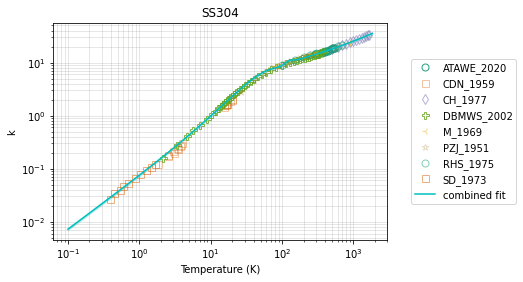

<Figure size 432x288 with 0 Axes>

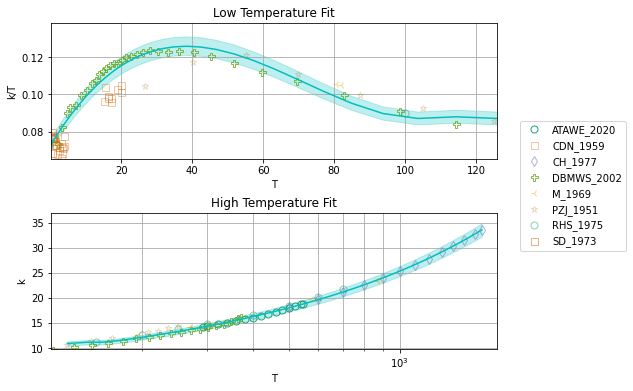

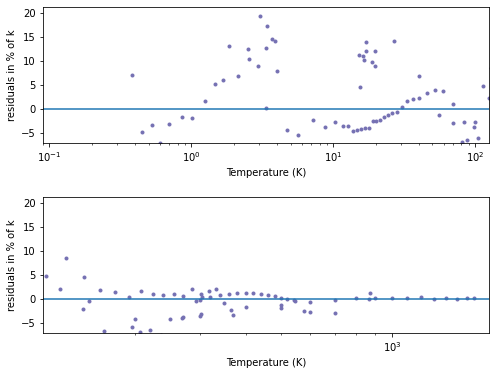

In [4]:
from tc_utils import *

for mat in path_to_RAW.keys():
    perc_diff_avg = np.array([])
    ## First, let's collect the raw data from their csv files
    big_data, data_dict = parse_raw(mat, path_to_RAW[mat], plots=False, weight_const=0.01)
    T, k, koT, weights = [big_data[:,0], big_data[:,1], big_data[:,2], big_data[:,3]]

    maxT, minT = [max(T), min(T)]
    fit_orders = [3,3]
    fit_types = ["k/T", "loglog"]

    print(maxT, minT)

    if (maxT <= 20):
        print(f"Using a low fit.")
        low_fit_xs, low_fit = koT_function(T, koT, fit_orders[0], weights)
        hi_fit, hi_fit_xs, erf_loc = [[0], [0], [0]]
        fit_args = make_arg_dict(low_fit, low_fit_xs, hi_fit, hi_fit_xs, fit_orders, fit_types, erf_loc)
    elif (minT >= 20):
        print(f"Using a hi fit.")
        hi_fit_xs, hi_fit = logk_function(np.log10(T), np.log10(k), fit_orders[1], weights)
        low_fit, low_fit_xs, erf_loc = [[0], [0], [-1]]
        fit_args = make_arg_dict(low_fit, low_fit_xs, hi_fit, hi_fit_xs, fit_orders, fit_types, erf_loc)
    else:
        print(f"Using a combined fit.")
        erf_locList = np.linspace(np.sort(T)[0], np.sort(T)[-1], 15)
        print(erf_locList)
        for erf_loc in erf_locList:
            dsplit = split_data(big_data, erf_loc)
            lowT, lowT_k, lowT_koT, low_ws, hiT, hiT_k, hiT_koT, hi_ws = dsplit
            # Take a log10 of the high range
            log_hi_T = np.log10(hiT)
            log_hi_k = np.log10(hiT_k)
            
            if (len(lowT)==0):
                low_fit = [0]
                print(f"Only using high fit {min(T)} > 20")
            else:
                low_fit_xs, low_fit = koT_function(lowT, lowT_koT, fit_orders[0], low_ws)
            if (len(hiT)==0):
                hi_fit = [0]
                print(f"Only using low fit {max(T)} < 20")
            else:
                hi_fit_xs, hi_fit = logk_function(log_hi_T, log_hi_k, fit_orders[1], hi_ws)
            print("erfloc", erf_loc)
            fit_args = make_arg_dict(low_fit, low_fit_xs, hi_fit, hi_fit_xs, fit_orders, fit_types, erf_loc)
            ## With the fit complete, let's output a formatted dictionary with the fit parameters
            output_array = make_fit_dict(fit_args)
            ## We want to figure out the best location for the split in data, so we will compute the residual of the combined fit
            # Tdata = np.concatenate([(data_dict[ref_name].T[0]) for ref_name in data_dict])
            # kdata = np.concatenate([(data_dict[ref_name].T[1]) for ref_name in data_dict])
            low_param, hi_param, erf_param = fit_args["low_fit_param"], fit_args["hi_fit_param"], fit_args["combined_fit_param"][-1]
            kpred = loglog_func(T, low_param, hi_param, erf_param)
            # and append it to the array resVal
            diff = abs(kpred-k)
            perc_diff_arr = 100*diff/kpred
            # print((kpred-kpred*perc_diff_arr)[Tdata.argsort()])
            perc_diff_avg = np.append(perc_diff_avg, np.mean(perc_diff_arr))

        # plt.plot(erf_locList, perc_diff_avg)
        # plt.show()
        # Now that we have found the residuals of the fits for many different split locations, let's choose the best one.    
        erf_locdict = dict(zip(erf_locList, perc_diff_avg))
        bestRes = min(erf_locdict.values())
        besterf_loc = [key for key in erf_locdict if erf_locdict[key] == bestRes]
        print(f"Low-Hi split centered at : {besterf_loc[0]} ~~ with average percent difference value of: {bestRes:.2f}%")
        
        # We will repeat the above fit with this new 'optimized' split location
        fit_args = dual_tc_fit(big_data, os.path.split(path_to_RAW[mat])[0], erf_loc=besterf_loc, fit_orders=(3, 3), plots=False)
    
    output_array = make_fit_dict(fit_args)

    # Finally, we will output the fit parameters as a csv, and lh5 file - and plot the data.
    create_data_table(output_array, f"{os.path.split(path_to_RAW[mat])[0]}\\{os.path.split(os.path.split(path_to_RAW[mat])[0])[1]}.txt")
    create_tc_csv(output_array, f"{os.path.split(path_to_RAW[mat])[0]}\\{os.path.split(os.path.split(path_to_RAW[mat])[0])[1]}.csv")
    make_fit_lh5(fit_args, os.path.split(path_to_RAW[mat])[0])
    # PLOTTING CODE
    tk_plot(mat,path_to_RAW, data_dict, fit_args, fit_range = [100e-3, np.sort(T)[-1]], points=True, fits="combined", fill=True)

Finally, lets output a single human readable (and CSV) file of the fits for each material currently in the library.

In [5]:
output_array = compile_csv(path_to_RAW)
create_data_table(output_array, "..\\thermal_conductivity_compilation.txt")
create_tc_csv(output_array, "..\\thermal_conductivity_compilation.csv")

The following cell is an example of what can be done with the output csv file

In [6]:
current_year = 2024
test_year = 1973

print(0.01*(current_year-test_year))


0.51
